In [436]:
import pymysql
import numpy as np
import pandas as pd

connection = pymysql.connect(host='1.117.74.41',
                             user='xiecheng',
                             password='xiecheng',
                             database='xiecheng',
                             cursorclass=pymysql.cursors.DictCursor)

with connection:
    with connection.cursor() as cursor:
        sql = "SELECT * FROM  `xiecheng_ticket` order by id desc"

        data = pd.read_sql(sql, connection)

In [444]:
tickets = data.copy(deep=True)

# 数据预处理

In [445]:
print("特征维度：", tickets.shape[1])
print("数据大小：", tickets.shape[0])
print(tickets.info())

import sys
tickets.iloc[18:20, 10:]

特征维度： 27
数据大小： 115059
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115059 entries, 0 to 115058
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  115059 non-null  int64         
 1   craft_1             115059 non-null  object        
 2   plane_name_1        115059 non-null  object        
 3   company_1           115059 non-null  object        
 4   craft_2             115059 non-null  object        
 5   plane_name_2        115059 non-null  object        
 6   company_2           115059 non-null  object        
 7   arrival_airport     115059 non-null  object        
 8   arrival_terminal    115059 non-null  object        
 9   arrival_time        115059 non-null  object        
 10  cross_day           115059 non-null  object        
 11  departure_time      115059 non-null  object        
 12  departure_airport   115059 non-null  object        
 13  departu

,cross_day,departure_time,departure_airport,departure_terminal,departure_week,in_time,craft_size,meat,flyman,economy_price,busniess_price,total_time,transit,transit_time,departure_city,arrival_city,create_time
18,0,2022-08-04 12:20:00,浦东机场,浦东T1,周四,100,中机型,,0,1350.0,0.0,7h35m,昆明,1h20m,上海,济南,2022-07-06 10:27:37
19,0,2022-08-04 13:20:00,虹桥机场,虹桥T2,周四,97,中机型,,0,1656.0,4432.0,7h,西安,2h35m,上海,济南,2022-07-06 10:27:37


可以发现所有字段都不存在null类型的值，但这不代表数据都是完整的，可能存在空字符串，下面对空字符串进行处理

In [446]:
tickets.replace(to_replace="^\s*$", regex=True, value=np.nan, inplace=True)
tickets.info()
# tickets.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115059 entries, 0 to 115058
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  115059 non-null  int64         
 1   craft_1             114956 non-null  object        
 2   plane_name_1        115059 non-null  object        
 3   company_1           115059 non-null  object        
 4   craft_2             11515 non-null   object        
 5   plane_name_2        11524 non-null   object        
 6   company_2           11524 non-null   object        
 7   arrival_airport     115059 non-null  object        
 8   arrival_terminal    115059 non-null  object        
 9   arrival_time        115059 non-null  object        
 10  cross_day           115059 non-null  object        
 11  departure_time      115059 non-null  object        
 12  departure_airport   115059 non-null  object        
 13  departure_terminal  115059 no

1. craft_2、plane_name_2、company_2、transit、transit_time代表中转的航班，大多为空值。--->暂时直接删除行，后期可能单独对这类航班进行分析
2. in_time为准点率，有第三方提供，所以可能没有。--->缺省的以均值填充
3. craft_1、craft_size、meat部分官方没有提供数据，所以也存在少量空值。--->craft_1行删除、craft_size列删除或者以众数填充、meat空值以不提供填充

下面对缺失值处理：

In [447]:
# 先要将一些数据转化为number类型,下面计算需要用到数值类型
def time2num(total_time):
    try:
        if 'm' in total_time and 'h' in total_time:
            hour, minute = total_time.split("h")
            hour = int(hour)
            minute = int(minute.split("m")[0])
        elif 'm' in total_time:
            hour = 0
            minute = int(total_time.strip('m'))
        elif 'h' in total_time:
            minute = 0
            hour = int(total_time.strip('h'))
        else:
            minute = 0
            hour = 0
            print(f"error:{total_time}")
        return minute + hour*60
    except Exception as e:
        print(e, total_time)

def to_int(s):
    global t
    try:
        if not isinstance(s, str):
            return s
        return int(float(s))
    except:
        print("error:", s)


tickets.total_time = tickets.total_time.apply(time2num)
tickets.in_time = tickets.in_time.apply(to_int)
tickets.departure_week = tickets.departure_week.map({
    "周一":1,
    "周二":2,
    "周三":3,
    "周四":4,
    "周五":5,
    "周六":6,
    "周七":7,
})
tickets_t = tickets.copy(deep=True)
tickets_t.in_time.apply(to_int).head()

0    100.0
1    100.0
2     97.0
3     97.0
4    100.0
Name: in_time, dtype: float64

In [449]:
t = tickets.copy(deep=True)
tickets.head()

,id,craft_1,plane_name_1,company_1,craft_2,plane_name_2,company_2,arrival_airport,arrival_terminal,arrival_time,...,meat,flyman,economy_price,busniess_price,total_time,transit,transit_time,departure_city,arrival_city,create_time
0,115059,波音738(中),南航CZ4482,南方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 12:40:00,...,有小食,0,1490.0,5000.0,90,NaN,NaN,上海,福州,2022-07-06 10:27:49
1,115058,波音738(中),南航CZ4450,南方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 15:20:00,...,有餐食,0,1490.0,5000.0,85,NaN,NaN,上海,福州,2022-07-06 10:27:49
2,115057,波音738(中),南航CZ4456,南方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 19:00:00,...,有餐食,0,1490.0,5000.0,90,NaN,NaN,上海,福州,2022-07-06 10:27:49
3,115056,空客321(中),东航MU5662,东方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 12:25:00,...,NaN,0,598.0,963.0,105,NaN,NaN,上海,福州,2022-07-06 10:27:49
4,115055,空客32L(中),东航MU5505,东方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 10:30:00,...,有小食,0,598.0,963.0,115,NaN,NaN,上海,福州,2022-07-06 10:27:49


In [458]:
tickets.arrival_time = pd.to_datetime(tickets.arrival_time)
tickets.departure_time = pd.to_datetime(tickets.departure_time)
tickets['ahead'] =  (tickets.departure_time - tickets.create_time).apply(lambda x:x.days)
tickets.head()

,id,craft_1,plane_name_1,company_1,craft_2,plane_name_2,company_2,arrival_airport,arrival_terminal,arrival_time,...,flyman,economy_price,busniess_price,total_time,transit,transit_time,departure_city,arrival_city,create_time,ahead
0,115059,波音738(中),南航CZ4482,南方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 12:40:00,...,0,1490.0,5000.0,90,NaN,NaN,上海,福州,2022-07-06 10:27:49,29
1,115058,波音738(中),南航CZ4450,南方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 15:20:00,...,0,1490.0,5000.0,85,NaN,NaN,上海,福州,2022-07-06 10:27:49,29
2,115057,波音738(中),南航CZ4456,南方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 19:00:00,...,0,1490.0,5000.0,90,NaN,NaN,上海,福州,2022-07-06 10:27:49,29
3,115056,空客321(中),东航MU5662,东方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 12:25:00,...,0,598.0,963.0,105,NaN,NaN,上海,福州,2022-07-06 10:27:49,29
4,115055,空客32L(中),东航MU5505,东方航空,NaN,NaN,NaN,长乐机场,长乐,2022-08-04 10:30:00,...,0,598.0,963.0,115,NaN,NaN,上海,福州,2022-07-06 10:27:49,28


In [468]:
tickets = tickets[tickets[['craft_2', 'plane_name_2', 'company_2', 'transit', 'transit_time']].isna().sum(1)==5]
tickets['in_time'].fillna(value=tickets.in_time.mean(), inplace=True)
tickets.dropna(subset=['craft_1'], inplace=True)
tickets.craft_size.fillna(value=tickets.craft_size.mode(), inplace=True)
tickets.meat.fillna("无餐食", inplace=True)
tickets.departure_week = tickets.departure_time.apply(lambda x:x.weekday()+1)
tickets.dropna(axis=1, inplace=True)
tickets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103491 entries, 0 to 115058
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  103491 non-null  int64         
 1   craft_1             103491 non-null  object        
 2   plane_name_1        103491 non-null  object        
 3   company_1           103491 non-null  object        
 4   arrival_airport     103491 non-null  object        
 5   arrival_terminal    103491 non-null  object        
 6   arrival_time        103491 non-null  datetime64[ns]
 7   cross_day           103491 non-null  object        
 8   departure_time      103491 non-null  datetime64[ns]
 9   departure_airport   103491 non-null  object        
 10  departure_terminal  103491 non-null  object        
 11  departure_week      103491 non-null  int64         
 12  in_time             103491 non-null  float64       
 13  craft_size          103491 no

删除一些无用数据

In [469]:
del tickets['id']

In [470]:
tickets.reset_index(drop=True, inplace=True)
tickets_clean = tickets.copy(deep=True)

异常值处理（箱型图+3sigma原则）

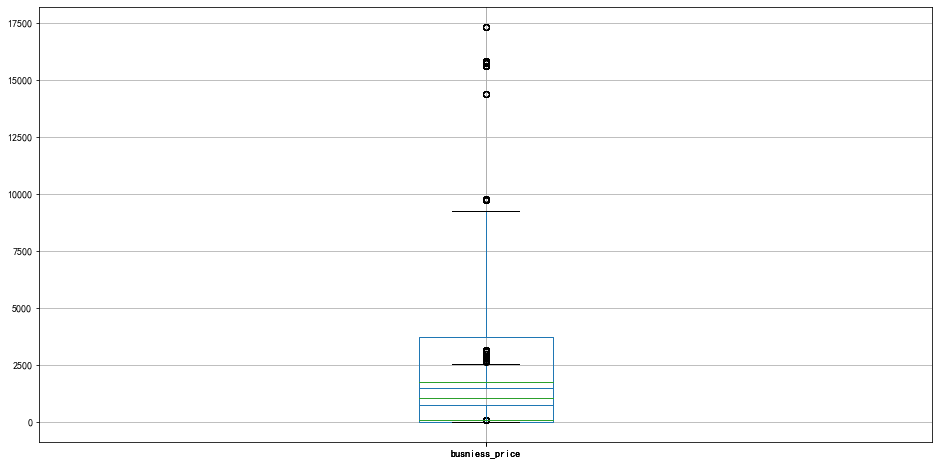

In [471]:
import matplotlib.pyplot as plt


plt.figure(figsize=(16,8))
c = 1
for i in tickets_clean.dtypes.index:
    if tickets_clean.dtypes[i] == np.float:
        # plt.subplot(3, 3, c)
        c += 1
        col = tickets_clean[[i]]
        col.boxplot()
        plt.savefig(f"D:/crawler/box/{i}.png")
plt.show()

由于有些航班没有商务舱的机票或者没有经济舱的机票，存在机票价格为0的情况，所以这里不做异常值处理，后面统计时再进行处理。

In [472]:
col_economy = np.array(tickets_clean["economy_price"])
mean_economy = col_economy.mean()
std_economy = col_economy.std()
outlier_index = np.arange(col_economy.shape[0])[(col_economy > (mean_economy + 3*std_economy)) | (col_economy < (mean_economy - 3*std_economy))]
print(outlier_index)
tickets_clean.drop(outlier_index, axis=0, inplace=True)


col_business = np.array(tickets_clean["busniess_price"])
mean_business = col_business.mean()
std_business = col_business.std()
outlier_index = np.arange(col_business.shape[0])[(col_business > (mean_business + 3*std_business)) | (col_business < (mean_business - 3*std_business))]
print(outlier_index)
tickets_clean.drop(outlier_index, axis=0, inplace=True)

[   174    181    182    188    189   1008   1019   1020   1027   1843
   1859   1860   1866   1867   2665   2666   2672   2674   2699   3495
   3496   3497   3503   3505   4293   4295   4296   4302   4303   5051
   5052   5058   5060   5088   5850   5851   5857   5858   6640   6641
   6647   6649   7436   7438   7439   7445   7446   8091   8233   8235
   8236   8242   8244   8994   8995   9001   9003   9032   9773   9774
   9780   9781   9805  10562  10563  10569  10571  10599  11364  11374
  11375  11381  11382  12165  12167  12168  12174  12176  12909  12910
  12916  12917  12945  13699  13700  13706  13708  13730  14495  14521
  15257  15275  16028  16767  17501  18236  18925  20534  20808  20810
  20812  20853  20856  20961  21078  21079  21080  21082  21151  21153
  21154  21360  21371  21372  21379  22166  22182  22183  22189  22190
  22960  22961  22967  22969  22994  23768  23769  23770  23776  23778
  24555  24557  24558  24564  24565  25296  25297  25303  25305  25333
  2609

In [397]:
# plt.figure()
# c = 1
# for i in tickets_clean.dtypes.index:
#     if tickets_clean.dtypes[i] == np.float:
#         # plt.subplot(3, 3, c)
#         c += 1
#         col = tickets_clean[[i]]
#         col.boxplot()
#         plt.savefig(f"D:/{i}2.png")
#
# plt.show()


先查看一下数据大致情况

In [473]:
tickets_clean.describe(include=np.number)

,departure_week,in_time,economy_price,busniess_price,total_time,ahead
count,102283.000000,102283.000000,102283.000000,102283.000000,102283.000000,102283.000000
mean,3.985609,98.419778,1126.573360,2375.722310,150.652015,15.775935
std,2.021068,2.262332,492.344228,2377.173938,38.659708,7.865323
min,1.000000,83.000000,0.000000,0.000000,85.000000,0.000000
25%,2.000000,98.415551,750.000000,0.000000,125.000000,9.000000
50%,4.000000,98.415551,1050.000000,1745.000000,150.000000,16.000000
75%,6.000000,100.000000,1430.000000,3730.000000,170.000000,23.000000
max,7.000000,100.000000,2650.000000,17345.000000,390.000000,29.000000


In [474]:
tickets_clean.describe(include=np.object)

,craft_1,plane_name_1,company_1,arrival_airport,arrival_terminal,cross_day,departure_airport,departure_terminal,craft_size,meat,flyman,departure_city,arrival_city
count,102283,102283,102283,102283,102283,102283,102283,102283,102283,102283,102283,102283,102283
unique,69,996,26,19,26,2,2,4,3,3,2,1,17
top,波音738(中),东航MU5189,东方航空,宝安机场,宝安T3,0,虹桥机场,虹桥T2,中机型,有小食,0,上海,深圳
freq,20963,270,27688,14902,14902,96179,63304,53677,82214,39276,102282,102283,14902


# 数据分析

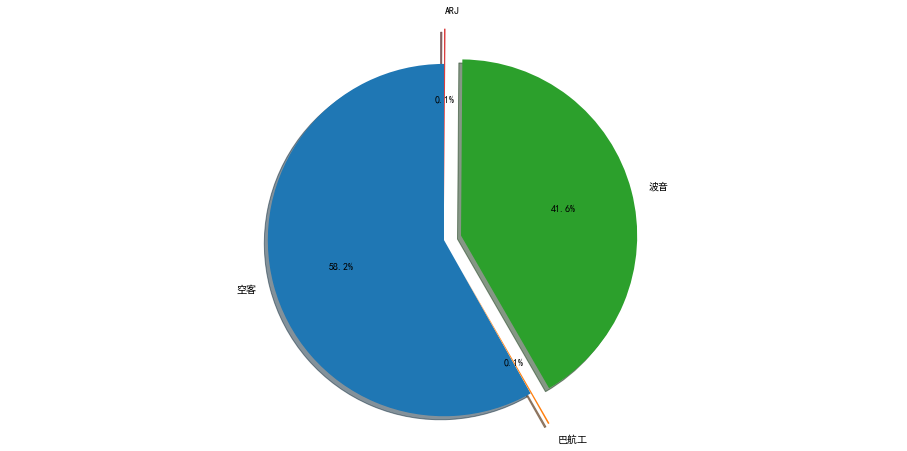

In [475]:
import re
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 飞机型号
craft = tickets_clean['craft_1'].copy(deep=True)
craft = craft.apply(lambda x:re.split("[\d|B]+", x[0:4])[0])
labels = craft.value_counts().index.values
sizes = craft.value_counts().values
t = labels[1]
labels[1] = labels[2]
labels[2] = t
t = sizes[1]
sizes[1] = sizes[2]
sizes[2] = t
explode = (0, 0.2, 0.1, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig = plt.figure(figsize=(16, 8))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("D:/crawler/pie/pie_craft.png")
plt.show()


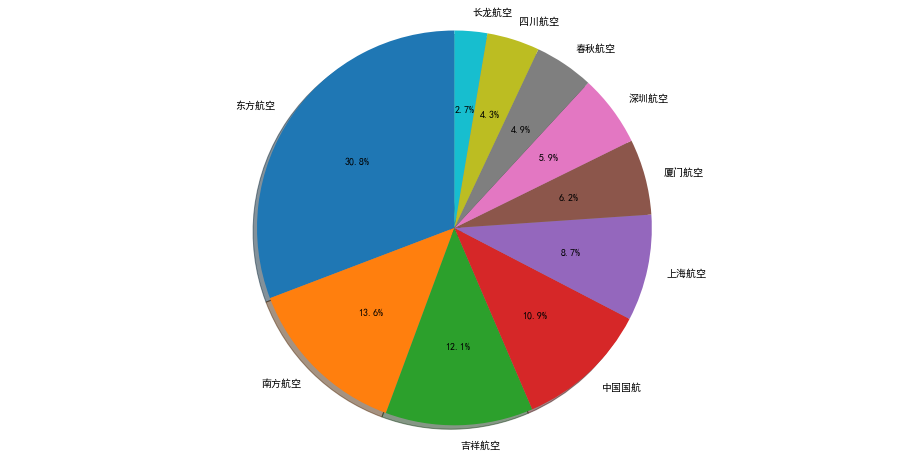

In [476]:
# 航空公司
airline = tickets_clean['company_1'].copy(deep=True)
labels = airline.value_counts().index.values[0:10]
sizes = airline.value_counts().values[0:10]

fig = plt.figure(figsize=(16, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("D:/crawler/pie/pie_airline.png")
plt.show()

In [477]:
# 对各个字段值的分布进行分析
# for col in ["departure_airport", "departure_week", "craft_size", "meat"]:
# for col in ["departure_week"]:
#     columns = tickets_clean[col]
#     labels = columns.value_counts().index.values
#     sizes = columns.value_counts().values
#     fig = plt.figure(figsize=(16, 8))
#     plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
#     plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#     plt.savefig(f"D:/crawler/pie/{col}.png")
#     plt.show()
tickets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102283 entries, 0 to 103490
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   craft_1             102283 non-null  object        
 1   plane_name_1        102283 non-null  object        
 2   company_1           102283 non-null  object        
 3   arrival_airport     102283 non-null  object        
 4   arrival_terminal    102283 non-null  object        
 5   arrival_time        102283 non-null  datetime64[ns]
 6   cross_day           102283 non-null  object        
 7   departure_time      102283 non-null  datetime64[ns]
 8   departure_airport   102283 non-null  object        
 9   departure_terminal  102283 non-null  object        
 10  departure_week      102283 non-null  int64         
 11  in_time             102283 non-null  float64       
 12  craft_size          102283 non-null  object        
 13  meat                102283 no

In [478]:
# 对准点率进行分析
in_time = tickets_clean['in_time']
print(f"最大准点率:{in_time.max()},对应的航空公司:\n{set(tickets_clean.company_1[in_time.nlargest(20).index.values].values)}")
print(f"准点率均值:{in_time.mean()}")

最大准点率:100.0,对应的航空公司:
{'海航旗下福航', '厦门航空', '中国国航', '吉祥航空', '上海航空', '长龙航空', '山东航空', '西藏航空', '南方航空', '东方航空'}
准点率均值:98.41977782323406


In [479]:
import datetime

# 对时间进行分析
def parse_time(s):
    hour = s.hour
    # print(dt)
    if 4 <= hour < 12:
        return 1
    elif 12<= hour < 18:
        return 2
    else:
        return 3

# 对小食进行分析
def parse_meat(s):
    if s == "有小食":
        return 1
    elif s=="有餐食":
        return 2
    else:
        return 3


tickets_numeric = pd.DataFrame({
    'departure_time':[],
    'arrival_time':[],
    'meat':[],
    'in_time':[],
    'total_time':[],
    'ahead':[]
})


tickets_numeric.departure_time = tickets_clean.departure_time.apply(parse_time)
tickets_numeric.arrival_time = tickets_clean.arrival_time.apply(parse_time)
tickets_numeric.meat = tickets_clean.meat.apply(parse_meat)
tickets_numeric.in_time = tickets_clean.in_time
tickets_numeric.ahead = tickets_clean.ahead
# tickets_numeric.economy_price = tickets_clean.economy_price
# tickets_numeric.business = tickets_clean.busniess_price
tickets_numeric.total_time = tickets_clean.total_time
tickets_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102283 entries, 0 to 103490
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   departure_time  102283 non-null  int64  
 1   arrival_time    102283 non-null  int64  
 2   meat            102283 non-null  int64  
 3   in_time         102283 non-null  float64
 4   total_time      102283 non-null  int64  
 5   ahead           102283 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 10.5 MB


In [480]:
# 对价格进行分析
from scipy.stats import pearsonr

for col_p in ['economy_price', 'busniess_price']:
    for col in tickets_numeric.columns:
        corr, p = pearsonr(tickets_clean[col_p], tickets_numeric[col])
        if abs(corr) <= 0.2:
            print(f"{col_p}和{col}相关性微小，相关系数为:{corr}({p})")
        elif abs(corr) <=0.5:
            print(f"{col_p}和{col}关系弱，相关系数为:{corr}({p})")
        elif abs(corr) <=0.8:
            print(f"{col_p}和{col}关系强，相关系数为:{corr}({p})")
        else:
            print(f"{col_p}和{col}关系密切，相关系数为:{corr}({p})")

economy_price和departure_time相关性微小，相关系数为:-0.0592653058146747(2.9902770928912904e-80)
economy_price和arrival_time相关性微小，相关系数为:-0.02727525301618026(2.6710030954282344e-18)
economy_price和meat相关性微小，相关系数为:-0.09728335868784224(1.624201292919899e-213)
economy_price和in_time相关性微小，相关系数为:-0.07823446143747825(1.3989236789719056e-138)
economy_price和total_time相关性微小，相关系数为:0.14492804031816447(0.0)
economy_price和ahead相关性微小，相关系数为:-0.04744545127989321(4.63725479579157e-52)
busniess_price和departure_time相关性微小，相关系数为:-0.018181094948977877(6.062111700327812e-09)
busniess_price和arrival_time相关性微小，相关系数为:0.003926828819396394(0.20916795271410699)
busniess_price和meat相关性微小，相关系数为:-0.1225962367873719(0.0)
busniess_price和in_time相关性微小，相关系数为:-0.11610454975952515(7.91348611979609e-304)
busniess_price和total_time相关性微小，相关系数为:0.1299114398096327(0.0)
busniess_price和ahead相关性微小，相关系数为:-0.021912853173079474(2.4026468666641188e-12)


从皮耳孙系数看出，票价和我们爬取到的这些特征值关联性不强，或者说是存在非线性的关系，所以接下去也不做线性回归的预测，先试试多项式回归看看是否可行。

In [483]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


linear_model = LinearRegression()
poly = PolynomialFeatures(degree=3)
poly.fit(tickets_numeric.values)
x = poly.transform(tickets_numeric.values)
linear_model.fit(x, tickets_clean.economy_price.values)
pre = linear_model.predict(x)
r2_score(pre.reshape(-1, 1), tickets_clean.economy_price.values.reshape(-1, 1))

-4.550240993934967

可以看到简单的根据服务、时长、准点率、购票提前的时间构建的多项式回归模型，并不能很好地预测机票价格。个人分析原因有三个：
- 一是因为机票价格受其他因素影响较大，比如说飞机运行的成本（油价、设备）、空乘人员的服务成本，也有受疫情影响的复杂因素，这些有的可以数值化，但获取的渠道少，有的是完全抽象的。
- 二是因为数据量少，我们当前使用的模型过于简单，越是简单的模型，想要训练出较好的结果，往往需要更多的数据（个人对传统机器学习没有经验，借鉴深度学习中模型训练结果来看）
- 三是机票类似股票，他是时序性的，上一个状态的特征对于当前状态是有影响的，比如说，前一段时间某航空公司销量不佳，紧急推出促销决策，这是之后的机票价格必然受影响。如果仅仅考虑当前状态，可能无法预测机票的价格，受限于时间，这里没有机会使用lstm去进行预测。

数值特征无法挖掘潜在关系，接下去，只能用消融的方法，看看票价和一些特征的关联

In [542]:
# 不同公司的机票价格平均值
tickets_clean.groupby("company_1").mean()['economy_price']
# tickets_clean.groupby(["company_1", 'ahead']).mean()[['economy_price', 'busniess_price']]

# 根据目的地、查询日期和出发日期分组
# tickets_clean.create_time = tickets_clean.create_time.apply(lambda x:x.strftime("%Y-%m-%d"))
# tickets_clean.departure_time = pd.to_datetime(tickets_clean.departure_time)
# tickets_clean.departure_time = tickets_clean.departure_time.apply(lambda x:x.strftime("%Y-%m-%d"))
group_time = tickets_clean.groupby(["company_1", "arrival_city", 'create_time', 'ahead']).mean()[['economy_price', 'busniess_price']]
# 根据ahead制作热力图
group_time

economy_price  busniess_price
company_1 arrival_city create_time ahead                               
上海航空      三亚           2022-07-02  0        1494.000000     6772.000000
                                   1        1494.000000     6772.000000
                                   2        1992.000000     9717.666667
                                   3        1995.333333     9717.666667
                                   4        1817.500000     6772.000000
...                                                 ...             ...
长龙航空      长沙           2022-07-06  25        910.000000        0.000000
                                   26       1820.000000        0.000000
                                   27       1820.000000        0.000000
                                   28       1820.000000        0.000000
                                   29       1820.000000        0.000000

[22369 rows x 2 columns]

In [566]:
dep_date = np.sort(list(set([i[2] for i in group_time.index])))
ls = []
for date in dep_date:
    t = group_time.loc[('上海航空', '三亚', date)]['economy_price'].values
    if len(t)<30:
        for i in range(30 - len(t)):
            t = list(t)
            t.append(0)
            t = np.array(t)
    ls.append(t)
# np.array(ls, dtype=np.float)
np.array(ls)

array([[1494.        , 1494.        , 1992.        , 1995.33333333,
        1817.5       , 1942.        , 2008.33333333, 1710.        ,
        1793.        , 1710.        , 1710.        , 1892.66666667,
        1892.66666667, 1892.66666667, 1793.        , 1793.        ,
        1793.        , 1793.        , 1992.33333333, 1892.66666667,
        1793.        , 1693.33333333, 1793.        , 1693.33333333,
        1693.33333333, 1693.33333333, 1693.33333333, 1693.33333333,
        1693.33333333,    0.        ],
       [1494.        , 1793.        , 1663.5       , 1987.66666667,
        1935.5       , 1810.5       , 2002.33333333, 1806.33333333,
        1790.        , 1706.66666667, 1706.66666667, 1892.66666667,
        1892.66666667, 1992.33333333, 1790.        , 1790.        ,
        1790.        , 1793.66666667, 1992.33333333, 1879.        ,
        1779.        , 1680.        , 1779.        , 1680.        ,
        1680.        , 1680.        , 1680.        , 1680.        ,
        1

AttributeError: 'numpy.ndarray' object has no attribute 'diff'

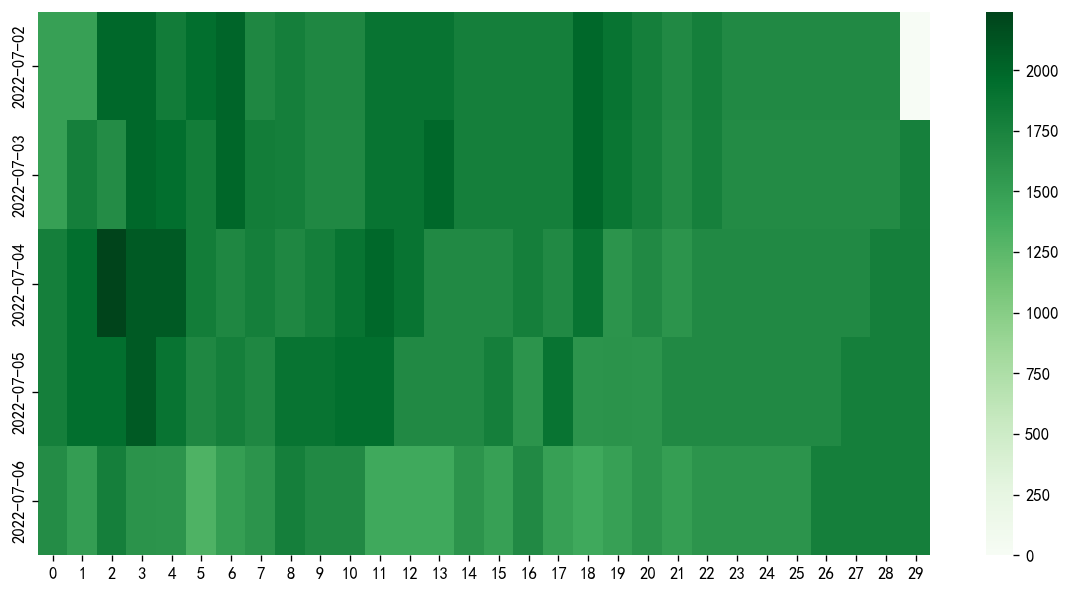

In [568]:
import seaborn as sns

cities = np.sort(list(set([i[1] for i in group_time.index])))
create_time = np.sort(list(set([i[2] for i in group_time.index])))
ahead = list(range(30))
ls = []
for date in dep_date:
    t = group_time.loc[('上海航空', '三亚', date)]['economy_price'].values
    if len(t)<30:
        for i in range(30 - len(t)):
            t = list(t)
            t.append(0)
            t = np.array(t)
    ls.append(t)
dep_ahead = np.array(ls)

fig = plt.figure(figsize=(12, 6), dpi=120)
sns.heatmap(
    data=dep_ahead,
    cmap=plt.get_cmap('Greens'),
    xticklabels=ahead, yticklabels=create_time
)

dep_ahead_diff = dep_ahead.diff()



# ax = plt.imshow(dep_ahead, cmap='cool', interpolation='nearest')
# plt.show()

# fig, ax = plt.subplots()
# im = ax.imshow(dep_ahead)
#
# # Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(ahead)))
# ax.set_xticklabels([1,2,3,4,5])
# ax.set_yticks(np.arange(len(create_time)))
# ax.set_xticklabels(create_time)
#
# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
#
# # Loop over data dimensions and create text annotations.
# for i in range(len(create_time)):
#     for j in range(len(ahead)):
#         text = ax.text(j, i, dep_ahead[i, j],
#                        ha="center", va="center", color="w")
#
# fig.tight_layout()
# plt.show()

In [ ]:
从上图可以看出的在起飞前的一个礼拜和一个月购买机票的价格最高，最便宜的时候是起飞前的两到三个礼拜。